<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.01.Colab_Cloud_Statistics_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Landsat-8 Cloud Statistics

This notebook uses global Landsat-8 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The selected data is used to calculate cloud statistics for selected regions. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

This baseline notebook runs in about 5 minutes after the Google authorization step is complete. The default region (0.15 degrees square) and time window (9 months) uses about 1 GB of the allocated 12 GB of RAM and about 38 GB of the 100 GB of storage. Selecting larger regions and time windows should be done carefully to avoid exceeding the system limits or having long run times.

Look for the "MODIFY HERE" tags to identify code blocks for user editing. These areas will allow the user to change the region, time window and output time slice. 

In [ ]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
import xarray as xr

In [6]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

In [7]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Mombasa, Kenya
lat_long = (-4.03, 39.62)
box_size_deg = 0.15

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Select a time range
# The inputs require a format (Min,Max) using this date format (YYYY-MM-DD)
# The Landsat-8 allowable time range is: 2013-04-07 to current
time_extents = ('2021-01-01', '2021-09-30')

In [8]:
# The code below renders a map that can be used to view the region.
# It is possible to find new regions using the map below. 
# Use your mouse to zoom in/out to explore new regions
# Click on the map to view Lat-Lon coordinates of any location that could define the region boundary

from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [9]:
from utils.data_cube_utilities.build_cloud_coverage_table_landsat import build_cloud_coverage_table_landsat
import pandas as pd

In [10]:
# Load the metadata for the given region and time period
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(dc=dc,
                                                                     product=product,
                                                                     platform=platform,
                                                                     collection='c1',
                                                                     level='l2',
                                                                     latitude=latitude,
                                                                     longitude=longitude,
                                                                     time=time_extents,
                                                                     extra_band='green')[0:2]

## Create a table of cloud coverage percentage for each date
This table displays each time slice in the cube (starting at ZERO). The "clean percentage" is the percent of pixels WITHOUT clouds. So, low numbers are cloudy scenes and high numbers are clearer scenes. The "clean count" is the number of clear pixels in the scene. 

Typically, there is a separation of 16 days between Landsat-8 views for a single location. When there is significant cloud cover, scenes may be missing from time series due to issues with processing and geolocation.

In [11]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2021-01-07 07:31:51.649,11.817661,36730
1,2021-03-12 07:31:30.244,26.334112,81848
2,2021-03-28 07:31:24.871,99.924068,310570
3,2021-04-13 07:31:19.595,37.087122,115269
4,2021-05-15 07:31:12.531,60.799341,188968
5,2021-07-02 07:31:31.215,16.115519,50088
6,2021-07-18 07:31:33.422,21.587099,67094
7,2021-08-03 07:31:41.725,58.854720,182924
8,2021-08-19 07:31:47.309,30.634865,95215


## Create a plot of cloud coverage percentage for each date
The y-axis is the "clean percentage" from the table above.

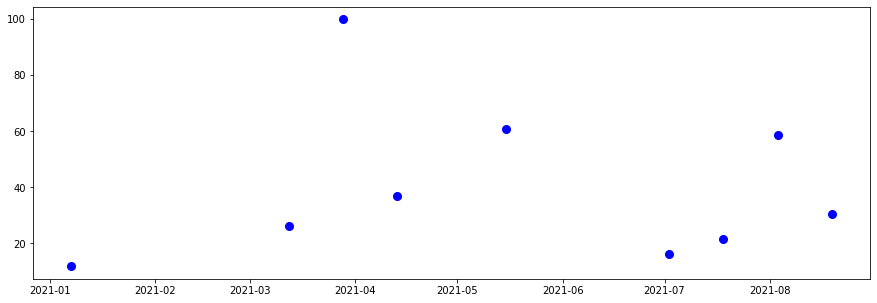

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

## Review an RGB scene for a selected time slice

In [13]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude=latitude,longitude=longitude,platform=platform,time=time_extents,
                          product=product,measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

In [14]:
# Load the plotting utility
from utils.data_cube_utilities.dc_rgb import rgb

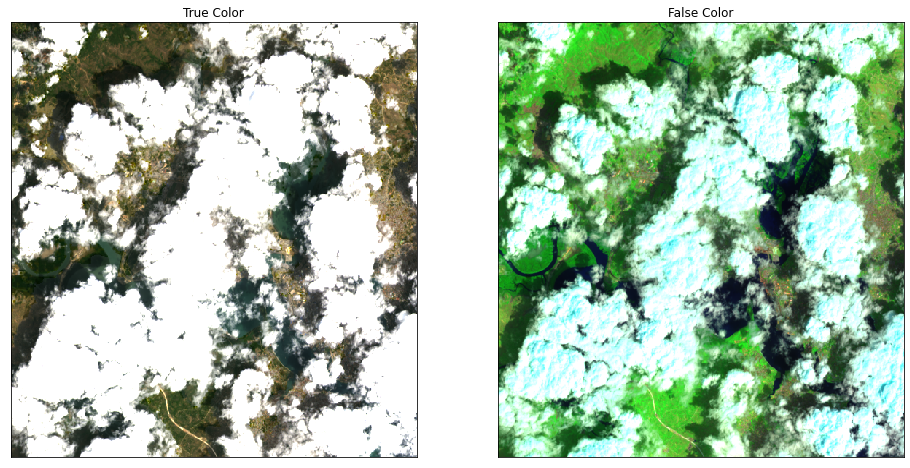

In [15]:
# MODIFY HERE

# Select one of the time slices and create an output image. 

# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an output image

slice = 0  # select the time slice number here

# Select the output image bands
# Users can create other combinations of bands (loaded above), as desired
# True-Color = red, green, blue (this is the common true-color RGB image)
# False Color = swir2, nir, green (this is commonly used for Landsat data viewing)

true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()

# Define the plot settings and show the plots
# Users may want to alter the figure sizes or plot titles
# The "vmax" value controls the brightness of the images and can be adjusted 

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=3000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()